In [1]:
!pip install python-binance torch scikit-learn pandas matplotlib ta --quiet


In [4]:
!pip install ccxt ta torch pandas matplotlib scikit-learn


Epoch 0, Loss: 0.219507
Epoch 10, Loss: 0.033617
Epoch 20, Loss: 0.021314
Epoch 30, Loss: 0.009399
Epoch 40, Loss: 0.005021


C:\Users\user\AppData\Local\Temp\ipykernel_24140\3306560201.py:102: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_24140\3306560201.py:102: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


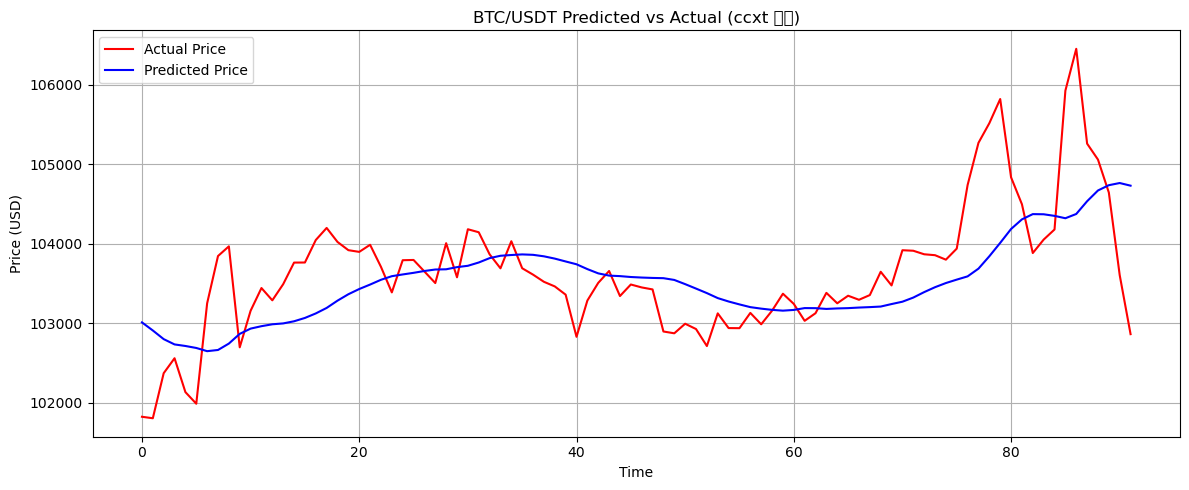

In [5]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import ta

# 1. ccxt를 통한 Binance 데이터 수집
def get_ccxt_data(symbol='BTC/USDT', timeframe='1h', limit=500):
    exchange = ccxt.binance()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df.astype(float)
    return df

df = get_ccxt_data()

# 2. 기술 지표 추가
df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
df['ema'] = ta.trend.EMAIndicator(close=df['close'], window=20).ema_indicator()
df['sma'] = df['close'].rolling(window=20).mean()
bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bb_bbm'] = bb.bollinger_mavg()
df['bb_bbh'] = bb.bollinger_hband()
df['bb_bbl'] = bb.bollinger_lband()

# 3. NaN 제거 및 정규화
df.dropna(inplace=True)
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'ema', 'sma', 'bb_bbm', 'bb_bbh', 'bb_bbl']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])

# 4. 시계열 입력 데이터 생성
window = 24
x_all, y_all = [], []
for i in range(len(scaled) - window):
    x_all.append(scaled[i:i+window])
    y_all.append(scaled[i+window][3])  # close 값

x_all = np.array(x_all)
y_all = np.array(y_all)

# 5. 학습 / 테스트 분리
train_size = int(len(y_all) * 0.8)
train_x = torch.tensor(x_all[:train_size], dtype=torch.float32)
train_y = torch.tensor(y_all[:train_size], dtype=torch.float32).view(-1, 1)
test_x = torch.tensor(x_all[train_size:], dtype=torch.float32)
test_y = torch.tensor(y_all[train_size:], dtype=torch.float32).view(-1, 1)

# 6. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = LSTMModel(input_size=train_x.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 7. 학습
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# 8. 예측
model.eval()
pred_y = model(test_x).detach().numpy()
real_y = test_y.numpy()

# 9. 역정규화
def inverse_close(scaled_close, original_data, feature_index=3):
    dummy = np.zeros((len(scaled_close), original_data.shape[1]))
    dummy[:, feature_index] = scaled_close.flatten()
    return scaler.inverse_transform(dummy)[:, feature_index]

pred_price = inverse_close(pred_y, scaled, feature_index=3)
real_price = inverse_close(real_y, scaled, feature_index=3)

# 10. 시각화
plt.figure(figsize=(12,5))
plt.plot(real_price, label='Actual Price', color='red')
plt.plot(pred_price, label='Predicted Price', color='blue')
plt.title('BTC/USDT Predicted vs Actual (ccxt 기반)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


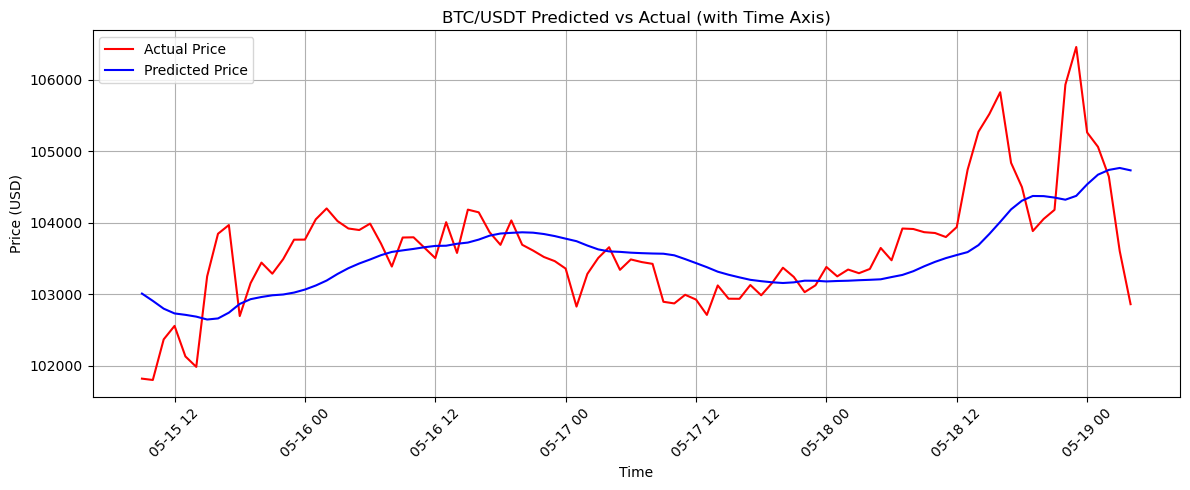

In [6]:
# 예측 대상이 되는 타임스탬프 추출
timestamps = df.index[window + train_size : window + train_size + len(test_y)]

# 시각화 (시간축 사용)
plt.figure(figsize=(12,5))
plt.plot(timestamps, real_price, label='Actual Price', color='red')
plt.plot(timestamps, pred_price, label='Predicted Price', color='blue')
plt.title('BTC/USDT Predicted vs Actual (with Time Axis)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

